In [1]:
def encoder(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters,3,padding = 'valid')(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(num_filters,3,padding = 'valid')(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.MaxPool2D(pool_size = (2,3), strides = 2)(x)

    return x


In [2]:
def decoder(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters,(2,3),strides = 2,padding = 'valid')(inputs)

    skip_features = tf.image.resize(skip_features,size = (x.shape[1],x.shape[2]))

    x = tf.keras.layers.Concatenate()([x,skip_features])

    x = tf.keras.layers.Conv2D(num_filters,3,padding = 'valid')(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(num_filters,3,padding = 'valid')(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x

In [3]:
import tensorflow as tf 

def unet_model(input_shape = (256,256,3), num_classes = 1):
    inputs = tf.keras.layers.Input(input_shape)

    s1 = encoder(inputs,64)
    s2 = encoder(s1,128)
    s3 = encoder(s2,256)
    s4 = encoder(s3,512)

    b1 = tf.keras.layers.Conv2D(2014,3,padding = 'valid')(s4)
    b1 = tf.keras.layers.Activation('relu') (b1)
    b1 = tf.keras.layers.Conv2D(1024,3, padding = 'valid')(b1)
    b1 = tf.keras.layers.Activation('relu')(b1)

    s5 = decoder(b1,s4,512)
    s6 = decoder(s5,s3,256)
    s7 = decoder(s6,s2,128)
    s8 = decoder(s7,s1,64)

    outputs = tf.keras.layers.Conv2D(num_classes,1,padding = 'valid', activation = 'sigmoid')(s8)

    model = tf.keras.models.Model(inputs = inputs,outputs = outputs , name = 'U-Net')

    return model



In [4]:
if __name__ == '__main__':
    model = unet_model(input_shape=(572,572,3), num_classes = 2)
    model.summary()



Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 572, 572, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 570, 570, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 570, 570, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 568, 568, 64)         36928     ['activation[0][0]']          
                                                                                            

In [5]:
import numpy as np 
from PIL import Image 
from tensorflow.keras.preprocessing import image 


In [6]:
img

NameError: name 'img' is not defined

1/1 [==============================] - 2s 2s/step


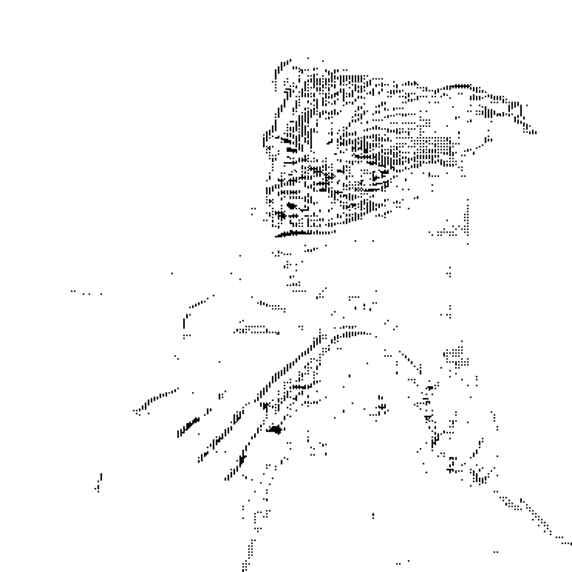

In [ ]:
img  = Image.open('images/dog.jpg')

img = img.resize((572,572))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array[:,:,:3], axis = 0)
img_array = img_array / 255.

model = unet_model(input_shape = (572,572,3), num_classes = 2)

predictions = model.predict(img_array)

predictions = np.squeeze(predictions,axis = 0)
predictions  = np.argmax(predictions,axis = -1)
predictions = Image.fromarray(np.uint8(predictions*255))
predictions = predictions.resize((img.width,img.height))

predictions.save('images/outputs/predicted_image.jpg')
predictions